# Clean notebook for attention maps

In [1]:
import os
print("CWD: ", os.getcwd())
import cortex
file_store = cortex.options.config.get('basic', 'filestore')
file_path = os.path.join(file_store, 'fsaverage', 'overlays.svg')
import numpy as np
import glob
import pylab
import pandas as pd
import time
import nibabel as nb
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
from collections import defaultdict
import seaborn as sns

CWD:  /home/hpcgies1/Masters-Thesis/AttemptFour/notebooks


2022-07-01 15:38:04.478978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/daal/lib/intel64_lin:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/ipp/lib/intel64:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/tbb/lib/intel64/gcc4.7:/usr/local/Cluster-Apps/intel/2017.4/debugger_2017/iga/lib:/usr/local/Cluster-Apps/intel/2017.4/debugger_2017/libipt/intel64/lib:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/mpi/intel64/lib:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/tbb/lib/intel64_lin/gcc4.7:/usr/local/Cluste

In [2]:
"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"


load glasser masks: 0.31
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


In [3]:
def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents


def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

def load_attn(file_path):
    return np.squeeze(np.load(file_path), axis=-1)

def get_attn_file(model_name):
    files = glob.glob(f"{log_dir}/{model_name}/eval_out/attention_*")
    print(model_name, "--", files[0].split("/")[-1])
    return files[0]

# Data Loader

In [142]:
log_dir = '/home/hpcgies1/rds/hpc-work/NIC/Log/'
plots_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/Plots'

In [5]:
mha = load_attn(get_attn_file('multi_head_attention'))  # [8, 515, 15 360]

multi_head_attention -- attention_scores_3.npy


In [6]:
sub1 = load_attn(get_attn_file('subject_1_layer_norm'))
sub2 = load_attn("../Log/subject_2_both_layer_norm/eval_out/attention_scores_25.npy")
sub5 = load_attn(get_attn_file('subject_5_layer_norm'))
sub7 = load_attn(get_attn_file('subject_7_layer_norm'))
# all_subs = load_attn(get_attn_file('multi_subject_torch_s1257'))
sub2_only = load_attn(get_attn_file('torch_s2'))
three_subs = load_attn(get_attn_file('multi_subject_torch_3subs'))
batch_subs = load_attn(get_attn_file('torch_alt_batches'))

subject_1_layer_norm -- attention_scores_28.npy
subject_5_layer_norm -- attention_scores_27.npy
subject_7_layer_norm -- attention_scores_28.npy
torch_s2 -- attention_scores_14.npy
multi_subject_torch_3subs -- attention_scores_14.npy
torch_alt_batches -- attention_scores_8.npy


In [402]:
batch_subs = np.load("/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/eval_out/attention_scores_8.npy")

In [403]:
batch_subs.shape

(8, 515, 15, 360, 1)

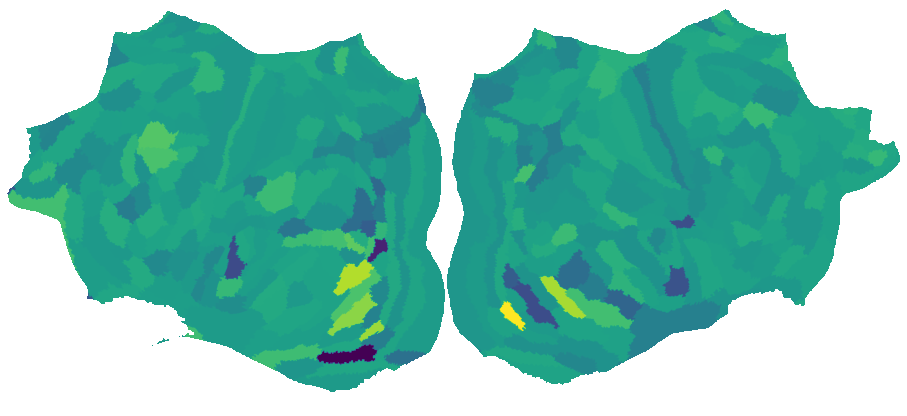

In [7]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = batch_subs#[1]
# d = np.mean(d, axis=(0,1))
d = (d - np.mean(d, axis=(0,1,2))) / np.std(d, axis=(0,1,2))
d = np.mean(d, axis=(0,1,2))

# d = d[88,0]
# d = np.log(d)
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.savefig(f"{plots_dir}/max_sub2.png", bbox_inches='tight')

plt.show()

241


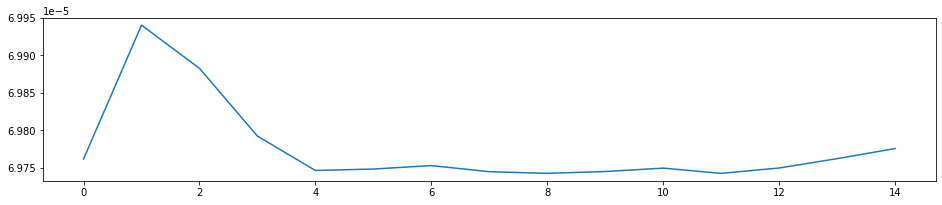

In [450]:
d = batch_subs[1]  # [515, 15, 360]

var = []
for trial in range(d.shape[0]):
    t = np.var(d[trial,:], axis=1)
    var.append(t)
var = np.array(var) # [515, 15, 1]

    
var_mean = np.mean(var, axis=0).flatten()
var_std  = np.std(var, axis=0).flatten()


plt.figure(figsize=(16,3))
plt.plot(var_mean)
# plt.errorbar(np.arange(var_mean.shape[0]), var_mean, yerr=var_std, capsize=10, color='black')

# plt.plot(var[241])

print(np.argmax(var))

plt.show()

(8, 515, 15, 360)


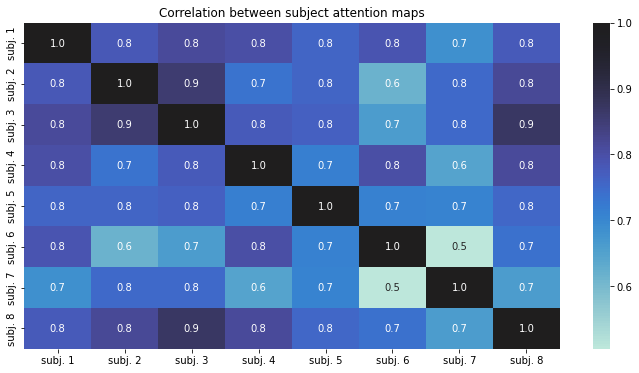

In [147]:
# a = np.array([np.mean(i, axis=(0,1)) for i in np.squeeze(batch_subs, -1)]).transpose(1, 0)
print(batch_subs.shape)
a = np.array([np.mean(i, axis=(0,1)) for i in batch_subs]).transpose(1, 0)
a = pd.DataFrame(a, columns=[f'subj. {i}' for i in range(1, 9)])

plt.figure(figsize=(12,6))
sns.heatmap(a.corr('pearson'), center=1., annot=True, fmt='.1f')
plt.title("Correlation between subject attention maps")
# plt.savefig(f"{home_dir}/Plots/correlation_between_subs.png", bbox_inches='tight')
plt.show()

(8, 515, 15, 360)


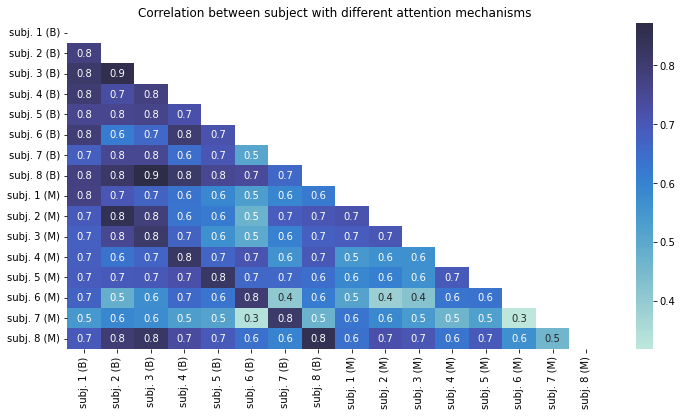

In [177]:
print(batch_subs.shape)
a = np.array([np.mean(i, axis=(0,1)) for i in batch_subs]).transpose(1, 0)
b = np.array([np.mean(i, axis=(0,1)) for i in mha]).transpose(1, 0)
c = np.concatenate((a,b), axis=-1)

cols = [f'subj. {i} (B)' for i in range(1, 9)] + [f'subj. {i} (M)' for i in range(1, 9)]
a = pd.DataFrame(c, columns=cols)

plt.figure(figsize=(12,6))
pcorr = a.corr('pearson').loc['subj. 1 (B)':'subj. 8 (M)']

matrix = np.triu(pcorr)

sns.heatmap(pcorr, center=1., annot=True, fmt='.1f', mask = matrix)
plt.title("Correlation between subject with different attention mechanisms")
plt.savefig(f"{plots_dir}/correlation_between_diff_attn.png", bbox_inches='tight')
plt.show()

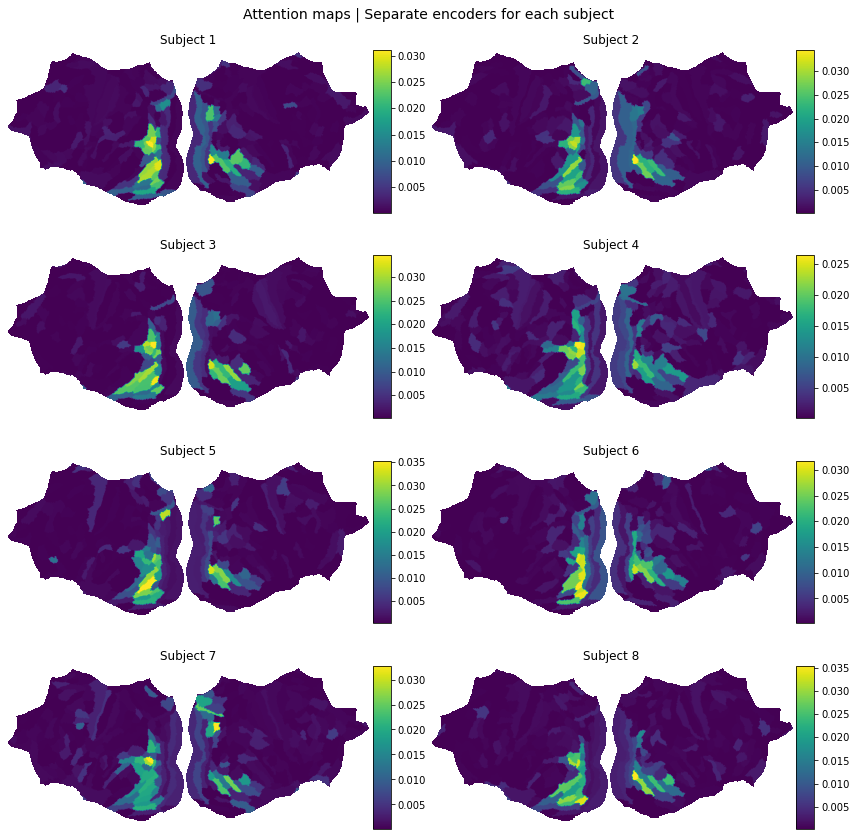

In [120]:
# 8 subjects
fig, ax = plt.subplots(4,2, figsize=(12,12))

for i, a in enumerate(ax.flatten()):
    d = batch_subs[i]
    d = np.mean(d, axis=(0,1))
#     d = np.log(d)
    im = a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject {i+1}")
    divider = make_axes_locatable(a)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.suptitle("Attention maps | Separate encoders for each subject", fontsize=14)
plt.tight_layout()
# plt.savefig(f"{plots_dir}/separate_encoders_mix_batches_min.png", bbox_inches='tight')
plt.show()

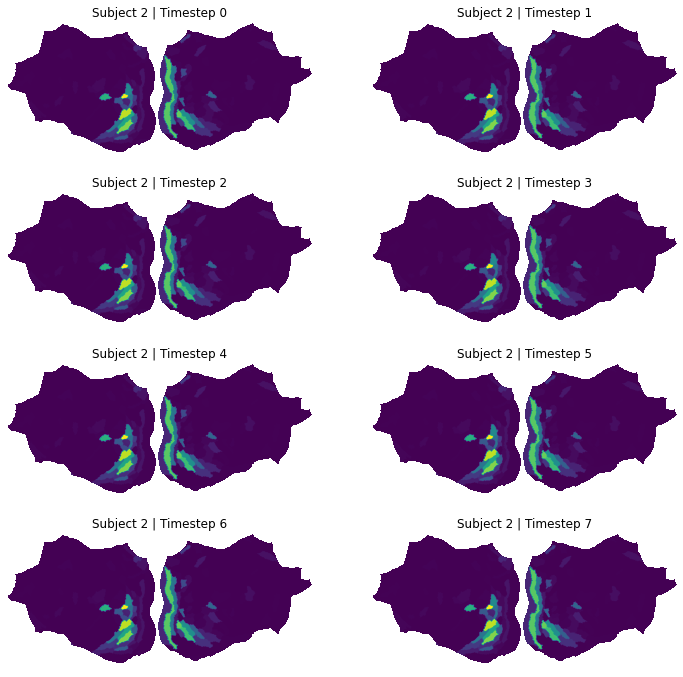

In [105]:
fig, ax = plt.subplots(4,2, figsize=(12,12))

for i, a in enumerate(ax.flatten()):
    idx = np.random.randint(0, 515)
    d = batch_subs[1, 0, i]
#     d = np.min(d, axis=(0))
#     d = np.log(d)
    a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject 2 | Timestep {i}")

# plt.savefig(f"{plots_dir}/sub2_diff_trials.png", bbox_inches='tight')
plt.show()

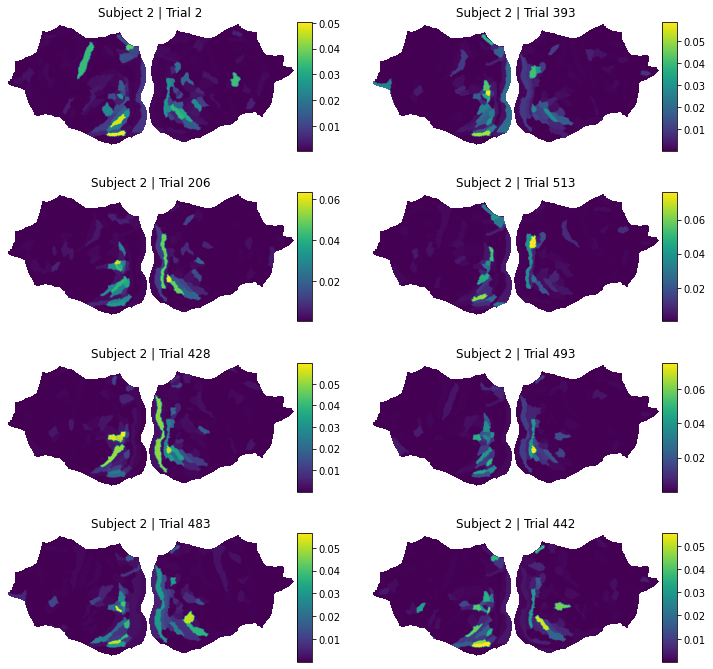

In [116]:
fig, ax = plt.subplots(4,2, figsize=(12,12))



for i, a in enumerate(ax.flatten()):
    idx = np.random.randint(0, 515)
    d = batch_subs[1, idx]
    d = np.min(d, axis=(0))
#     d = np.log(d)
    im = a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject 2 | Trial {idx}")
    divider = make_axes_locatable(a)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# plt.savefig(f"{plots_dir}/sub2_diff_trials.png", bbox_inches='tight')
plt.show()

0.00042723058
0.0006831254


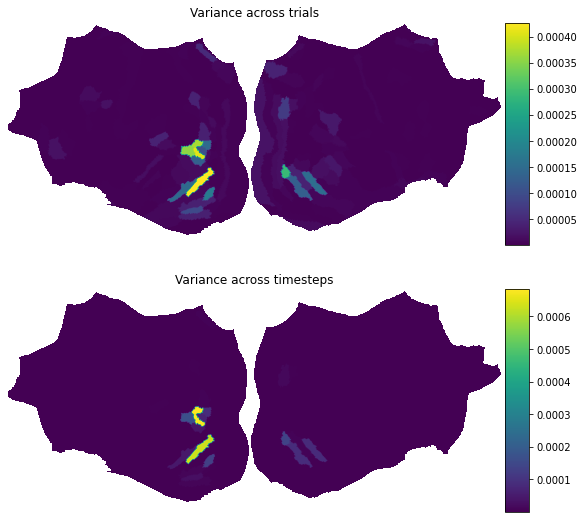

In [178]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2,1,figsize=(16,9))

# Variance across trials
d = batch_subs[1]
d = mha[1]
d = np.mean(d, axis=1) #avg timesteps
dvar = np.var(d, axis=0)
im0 = ax[0].imshow( get_flatmap(generate_plot( dvar ))[0] , cmap='viridis') 
ax[0].axis('off')
ax[0].set_title("Variance across trials")
print(max(dvar))
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

d = batch_subs[1]
d = mha[1]
d = np.mean(d, axis=0) #avg trials
dvar = np.var(d, axis=0)
im1 = ax[1].imshow( get_flatmap(generate_plot( dvar ))[0] , cmap='viridis') 
ax[1].axis('off')
ax[1].set_title("Variance across timesteps")
print(max(dvar))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

# plt.savefig(f"{plots_dir}/variance_of_attn_maps_sub2.png", bbox_inches='tight')
plt.show()

In [79]:
d = batch_subs[7]
d_max = np.max(d, axis=(0,1))
d_min = np.min(d, axis=(0,1))
d = np.mean(d, axis=(0,1))

d_idx = np.argsort(d)[::-1]
temp = []
for i in range(360):
#     print(i+1, "-", idx_to_region(d_idx[i])[0])
    temp.append( idx_to_region(d_idx[i])[1] )

    
for k, i in enumerate(temp):
    if i[0:2] == 'V1':
        print(i, k+1)

V1_R 57
V1_L 58


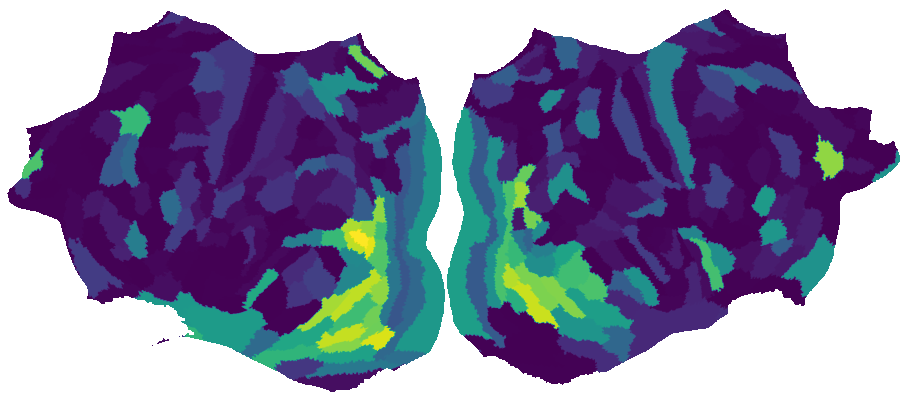

/home/hpcgies1/.conda/envs/pycor2/lib/python3.8/site-packages/cortex/dataset/braindata.py:487: UserWarning: Inverse mapping cannot be accurate
  warnings.warn('Inverse mapping cannot be accurate')


Started server on port 49840
   Loading data...


In [47]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = batch_subs[7]
d = np.max(d, axis=(0,1))

ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.show()

# d_idx = np.argsort(d)[::-1]
# for i in range(50):
#     print(i+1, "-", idx_to_region(d_idx[i])[0])


def generate_3d(x):
    """ Takes (360,) attention data """
#     x = normalise_(x)
    x = generate_plot(x)
    x = cortex.Vertex(x, 'fsaverage', vmin=0, vmax=1)
    x = x.volume('atlas_3mm')
    return x

three_d = generate_3d(d)
xx = cortex.webgl.show(data=three_d, autoclose=True, port=49840, cmap='viridis')


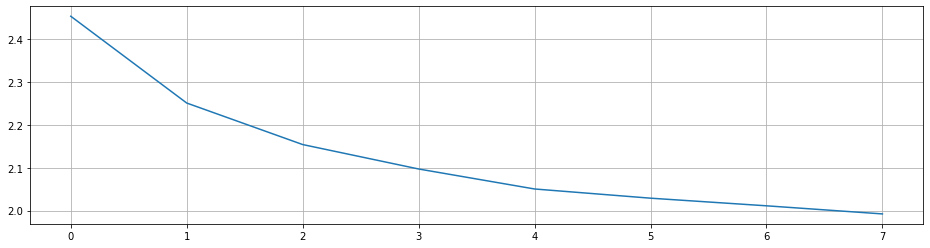

In [558]:
loss_df = pd.read_csv("/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/loss_history.csv")
loss = loss_df['loss'].values
loss = loss[-2226*8:]
val_loss = loss_df['val_loss'].values
val_loss = val_loss[-2304*8:]
# loss = loss[np.isfinite(loss)]
plt.figure(figsize=(16,4))
plt.grid()

def group_by_nan(a):
    """ Split 1D array on nan values """
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

loss = using_clump(loss)
loss = [np.mean(i) for i in loss]
val_loss = using_clump(val_loss)
val_loss = [np.mean(i) for i in val_loss]
plt.plot(val_loss)

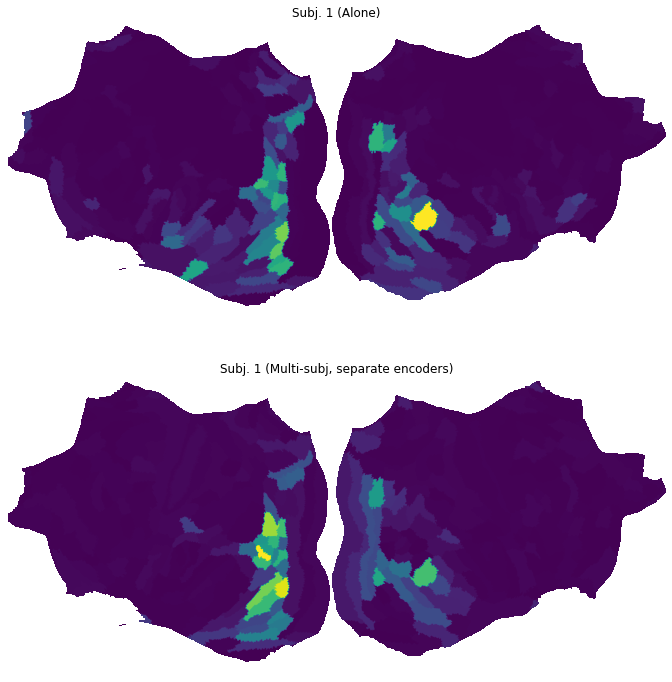

In [753]:
fig, ax = plt.subplots(2,1, figsize=(12,12))


d = np.min(sub1, axis=(0,1))
ax[0].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[0].axis('off')
ax[0].set_title("Subj. 1 (Alone)")

d = np.min(batch_subs[0], axis=(0,1))
ax[1].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[1].axis('off')
ax[1].set_title("Subj. 1 (Multi-subj, separate encoders)")

plt.show()

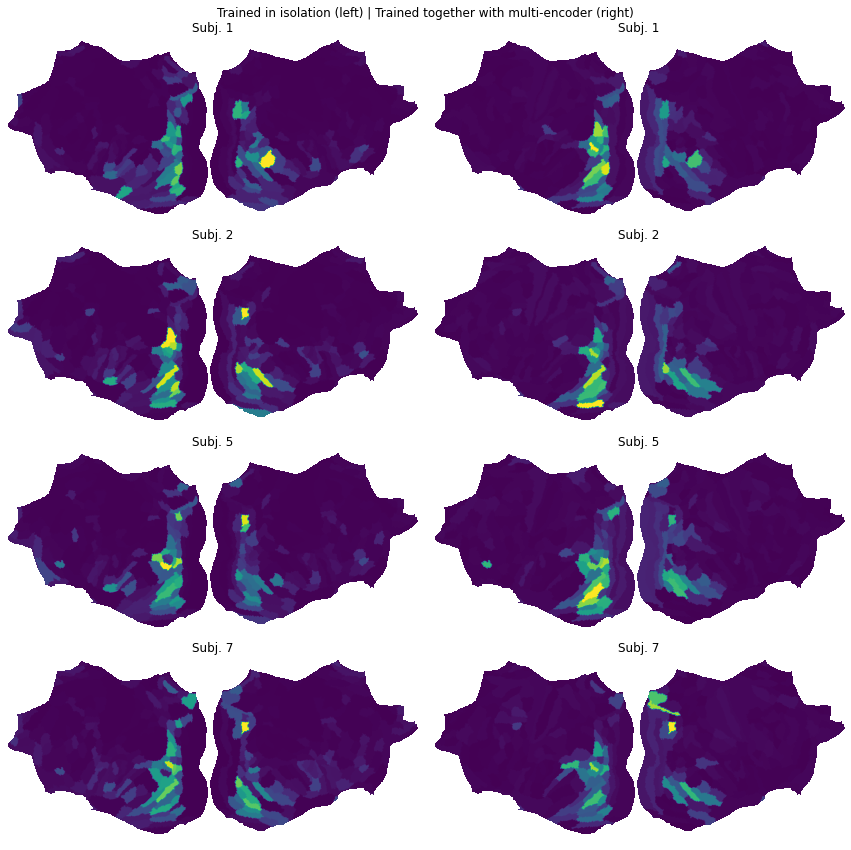

In [137]:
# sub1 
# sub2 
# sub5 
# sub7 
# sub2_only 
# three_subs 
# batch_subs 

ls = [sub1, batch_subs[0], sub2, batch_subs[1], sub5, batch_subs[4], sub7, batch_subs[6]]
ls_n = ['Subj. 1', 'Subj. 1', 'Subj. 2', 'Subj. 2', 'Subj. 5', 'Subj. 5', 'Subj. 7', 'Subj. 7']

fig, ax = plt.subplots(4,2, figsize=(12,12))
plt.suptitle("Trained in isolation (left) | Trained together with multi-encoder (right)")

for i, a in enumerate(ax.flatten()):
    
    d = ls[i]
    d = np.min(d, axis=(0,1))
    
    a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"{ls_n[i]}")
    

plt.tight_layout()
# plt.savefig(f"{plots_dir}/comparing_isolation_multi.png", bbox_inches='tight')
plt.show()

### Captions


In [328]:
keys = pd.read_csv(f'/home/hpcgies1/Masters-Thesis/AttemptFour/TrainData/subj02_conditions2.csv')
keys = keys.loc[keys['is_test'] == 1]
test_nsd_keys = keys['nsd_key'].values 

targets = defaultdict(list)

with open("/home/hpcgies1/rds/hpc-work/NIC/Data/captions/all_captions.txt", 'r') as f:
    content = f.read().splitlines()
    for line in content:
        x = line.split("\t")
        targets[x[0]] = x[1]

In [330]:
output = np.load('/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/eval_out/output_captions_8.npy')

tokenizer = f'/home/hpcgies1/rds/hpc-work/NIC/Log/torch_alt_batches/eval_out/tokenizer.json'
tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(open(tokenizer, 'r').read())

captions = tokenizer.sequences_to_texts(output[1])

def f(x):
    x = x.split(" ")
    x = [i for i in x if i != '<end>' and i != '<pad>']
    return " ".join(x)

for i in range(20,30):
    print(f(captions[i]))
    print(targets[str(test_nsd_keys[i])])
    print()

a cat is sitting on a bed with a laptop
A rest room with a shelf filled with items above a toilet.

a train traveling down tracks next to a train station
A city street showing traffic at a stoplight intersection 

a train traveling down tracks next to a train station
a public transit bus on a city street 

a man is standing in the snow with a snowboard
a baseball player is swinging his bat on a field

a large white airplane sitting on top of a runway
there are many boats docked in the water

a man is holding a tennis racket on a tennis court
A person in a black jacket flying a kite in the sky.

a train traveling down tracks next to a train station
A large long train on a steel track.

a plate with a sandwich and a fork on it
A vase that has flowers sitting on a piano.

a man riding a skateboard down a street
A man is flying a kite on a bare area near some residential buildings, street lamps, and a car.

a man and a woman standing in front of a bus
Two women playing tennis doubles on a 

In [206]:
loss = pd.read_csv('/home/hpcgies1/rds/hpc-work/NIC/Log/multi_subject_torch4/loss_history.csv')

loss = loss.groupby('sub').min()
loss.head(10)

,Unnamed: 0,epoch,batch,loss,accuracy,val_loss,val_accuracy
sub,,,,,,,
1,0,1,0,1.708382,0.000000,1.973931,0.494792
2,352,1,0,1.711639,0.417708,1.973839,0.494792
3,704,1,0,1.737759,0.458854,1.900503,0.535938
4,924,1,0,1.745259,0.456771,NaN,NaN
5,1117,1,0,1.709496,0.463021,1.761299,0.496354
6,1469,1,0,1.699982,0.480208,1.695991,0.538542
7,1689,1,0,1.708235,0.478125,1.782409,0.500000
8,2041,1,0,1.725581,0.481771,NaN,NaN


# Multi subs (separate encoders)

Weird attention maps, where the first couple show no activity, sub 3 or 4 shows super high activity everwhere, the rest show good (expected) results
   
    Ruled out: 
    1. layer norom on the LSTM not the problem

# Single subject maps

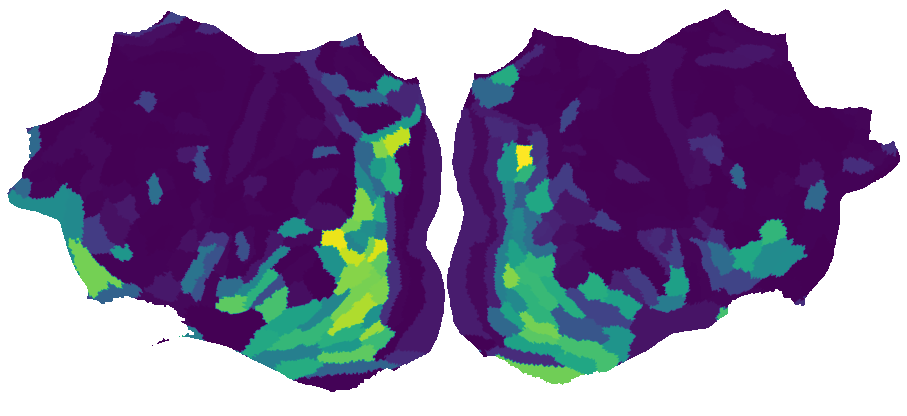

In [32]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = np.mean(sub5, axis=(0,1))
# d = sub1[0,0]
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.show()

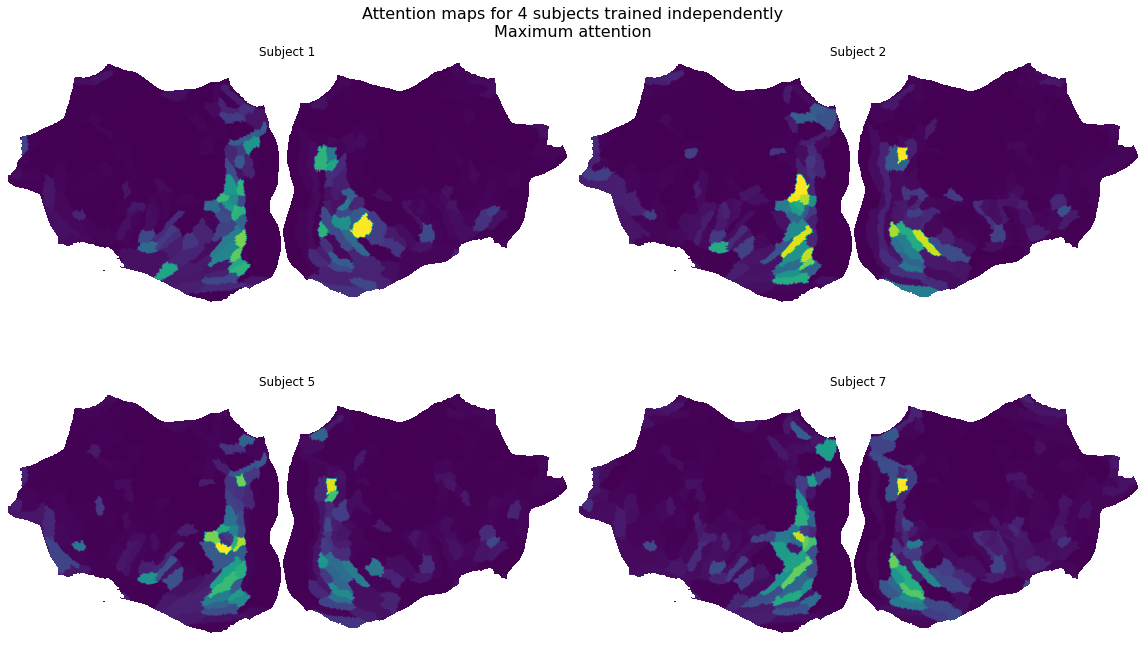

In [938]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

reduction = lambda x: np.min(x, axis=(0,1))

d = reduction(sub1)
ax[0,0].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[0,0].axis('off')
ax[0,0].set_title("Subject 1")

d = reduction(sub2)
ax[0,1].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[0,1].axis('off')
ax[0,1].set_title("Subject 2")

d = reduction(sub5)
ax[1,0].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[1,0].axis('off')
ax[1,0].set_title("Subject 5")

d = reduction(sub7)
ax[1,1].imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax[1,1].axis('off')
ax[1,1].set_title("Subject 7")

plt.tight_layout()
plt.suptitle("Attention maps for 4 subjects trained independently\nMaximum attention", fontsize=16)
# plt.savefig("/home/hpcgies1/Masters-Thesis/AttemptFour/Plots/sub1_2_5_7_ln.png", bbox_inches='tight')
plt.show()

# No Layer Norm

In [8]:
sub2_no_norm = load_attn(get_attn_file('subject_2_no_norm'))

NameError: name 'sub2_no_norm' is not defined

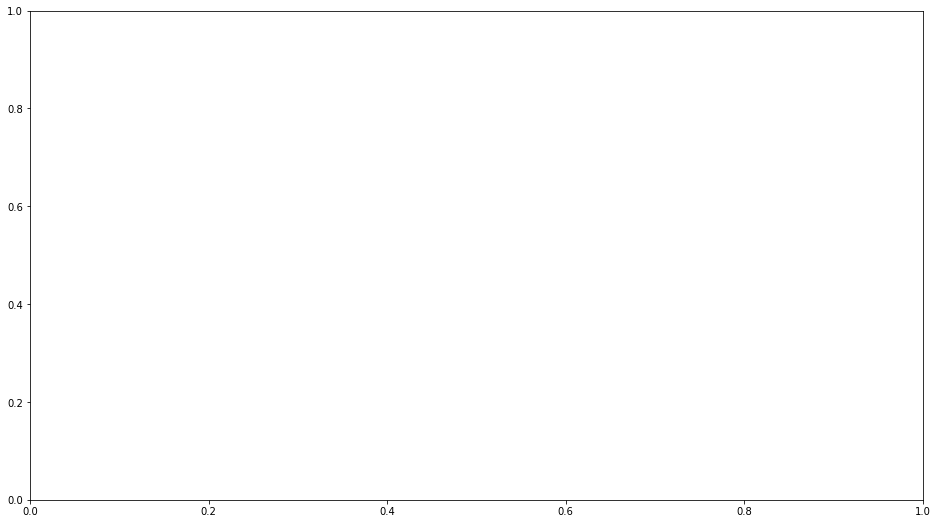

In [687]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = np.max(sub2_no_norm, axis=(0,1))
# d = sub2_no_norm[40,1]
# d = np.log(d)
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

plt.show()

In [962]:
df_regions = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
df_regions.head(10)

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
0,V1_L,Primary_Visual_Cortex_L,1_L,L,V1,Occ,Primary_Visual,1,1,100.491589,41.138901,71.637040,6717
1,MST_L,Medial_Superior_Temporal_Area_L,2_L,L,MST,Occ,MT+_Complex_and_Neighboring_Visual_Areas,2,5,132.416667,58.901786,82.059524,336
2,V6_L,Sixth_Visual_Area_L,3_L,L,V6,Occ,Dorsal_Stream_Visual,3,3,104.543112,44.481665,103.916749,1009
3,V2_L,Second_Visual_Area_L,4_L,L,V2,Occ,Early_Visual,4,2,102.236656,44.064791,74.401125,6220
4,V3_L,Third_Visual_Area_L,5_L,L,V3,Occ,Early_Visual,5,2,107.926111,40.632159,76.961153,4994
5,V4_L,Fourth_Visual_Area_L,6_L,L,V4,Occ,Early_Visual,6,2,120.481621,41.344329,69.955702,3183
6,V8_L,Eighth_Visual_Area_L,7_L,L,V8,Occ,Ventral_Stream_Visual,7,4,123.013193,51.892700,56.759015,1137
7,4_L,Primary_Motor_Cortex_L,8_L,L,4,Fr,Somatosensory_and_Motor,8,6,119.338359,105.485002,126.655610,6301
8,3b_L,Primary_Sensory_Cortex_L,9_L,L,3b,Par,Somatosensory_and_Motor,9,6,129.664059,103.257279,123.682747,2301
9,FEF_L,Frontal_Eye_Fields_L,10_L,L,FEF,Fr,Premotor,10,8,132.579336,118.837638,121.922509,813


In [870]:
df_regions.loc[df_regions['region'] == 'LO3']

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
158,LO3_L,Area_Lateral_Occipital_3_L,159_L,L,LO3,Occ,MT+_Complex_and_Neighboring_Visual_Areas,159,5,136.842415,48.964654,85.864507,679
338,LO3_R,Area_Lateral_Occipital_3_R,359_R,R,LO3,Par,MT+_Complex_and_Neighboring_Visual_Areas,359,5,41.930187,53.481809,85.433628,1017


In [935]:

par = list(df_regions['region'].loc[df_regions['Lobe'] == 'Par'].values)
occ = list(df_regions['region'].loc[df_regions['Lobe'] == 'Occ'].values) 
tem = list(df_regions['region'].loc[df_regions['Lobe'] == 'Temp'].values) 
fr = list(df_regions['region'].loc[df_regions['Lobe'] == 'Fr'].values) 
ins = list(df_regions['region'].loc[df_regions['Lobe'] == 'Ins'].values) 
intersection =  list(set(par).intersection(occ))
# print("intersection par | occ:", intersection)
# print("Temp | Occ",  list(set(fr).intersection(par)))

occ = [i for i in occ if i not in intersection]# + ['V6A', 'LO3']

ins = [i for i in ins if i not in ['52']]
fr  = [i for i in fr if i not in ['3b']]

par = [i for i in par if i not in ['LO3', 'V6A']]
occ = list(set(occ))
par = list(set(par))
tem = list(set(tem))
fr  = list(set(fr))
ins = list(set(ins))

# print(df_regions['Lobe'].unique())  # ['Occ' 'Fr' 'Par' 'Temp' 'Ins']
print(occ,"\n")
print(par,"\n")
print(tem,"\n")
print(fr, "\n")
print(ins,"\n")

['LO1', 'V6', 'VMV3', 'V7', 'LO2', 'VMV2', 'V3A', 'V4', 'V3CD', 'V3', 'MST', 'FST', 'V1', 'V8', 'VMV1', 'MT', 'PIT', 'V4t', 'V2', 'V3B'] 

['3b', 'AIP', '7Pm', '7PC', 'STV', 'OP2-3', 'POS2', 'PF', 'PGs', 'MIP', '5L', 'ProS', 'PSL', 'RI', 'RSC', '7Am', '31a', '5m', 'DVT', 'LIPv', 'VIP', '31pv', 'TPOJ3', '1', '7AL', 'PCV', 'v23ab', '7Pl', 'PGp', 'PFt', 'IP1', 'POS1', '31pd', 'PGi', '5mv', 'TPOJ2', '7m', 'OP4', 'PFm', '23d', 'd23ab', '2', 'IP2', '23c', 'PFcm', 'LIPd', 'IP0', 'OP1', 'PFop', 'IPS1'] 

['TE2a', 'TE1p', 'H', 'STSda', '52', 'TE2p', 'FFC', 'A1', 'VVC', 'TE1m', 'PI', 'PH', 'LBelt', 'STSvp', 'STSdp', 'TF', 'PeEc', 'EC', 'STSva', 'STGa', 'PHT', 'PreS', 'A5', 'A4', 'PHA1', 'Pir', 'PBelt', 'TGd', 'TPOJ1', 'TA2', 'PHA2', 'PHA3', 'TGv', 'MBelt', 'TE1a'] 

['10d', 'a9-46v', 's6-8', '11l', 'SCEF', 'p32', 'OFC', 'IFJa', 'p10p', 'p24', '9p', 'AVI', 'pOFC', '13l', '25', 'IFSp', '8Ad', '6a', 's32', '44', '6d', 'p9-46v', 'p47r', '4', '47m', '24dv', '47l', 'FEF', '3a', '46', '9-46d', '6v', '6

In [884]:
df_regions.loc[df_regions['region'] == 'V1'].index.values

array([  0, 180])

In [41]:
def idx_to_region(idx: int):
    """
    idx: int [0, 360)
    """
    df_regions = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
    return df_regions.iloc[idx].regionLongName, df_regions.iloc[idx].regionName, df_regions.iloc[idx].region

In [965]:
df_regions = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
df_regions['region'].head()

def region_to_idx(regs: list):
    df = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
    ls = []
    for r in regs:
        ls.extend(list(df.loc[df['region'] == r].index.values))
    return ls

fourseven = region_to_idx(['47m'])
print(fourseven)
raise

r_par = region_to_idx(par)
r_occ = region_to_idx(occ)
r_tem = region_to_idx(tem)
r_fr  = region_to_idx(fr)
r_ins = region_to_idx(ins)

def attn_amount(sub, regions:list):
    ls = []
    d = np.mean(sub, axis=(0,1))
    attn = d[regions]
    return np.sum(attn)
    
regions = {'Par':r_par, 'Occ':r_occ, 'Temp':r_tem, 'Fr':r_fr, "Ins":r_ins}
for lobe, r in regions.items():
    print("-------Lobe:", lobe, "-------")
    
    print("multi-subject:")
    ls = []
    for i in range(8):
        l = attn_amount(batch_subs[i], r)
        ls.append(l)
    print(np.mean(ls), np.std(ls))

    print("\nsingle subject")
    lss = [sub1, sub2, sub5, sub7]
    ls = []
    for i in lss:
        l = attn_amount(i, r)
        ls.append(l)
    print(np.mean(ls), np.std(ls))
    print()


[65, 245]


RuntimeError: No active exception to reraise

In [563]:
d_idx = np.argsort(d)[::-1]
for i in range(10):
    print(i+1, "-", idx_to_region(d_idx[i])[0])

1 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
2 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
3 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
4 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
5 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
6 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
7 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
8 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
9 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object
10 - 0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object


# Regions (annotated map)

    name (index)

1. V3A
2. Parieto Occipical Sulcus Area (14)
3. Fusiform face complex (17)
4. Eight visual area (6)
5. Primary motor (7)
6. Primary Sensory (8)
7. Lateral Occipital 1
8. Lateral Occipical 2
9. Posterior InferoTemporal complex (21)
10. PeriSylvian Language area (24)
11. Superior Temporal Visual area (27)
12. Parieto Occipical sulcus area 1 (30)
13. Area dorsal 23 (33)
14. Medial Area 7a (44)
15. Rostral Area 6 (77)
16. Area 10v (87)
17. Polar 10p (89)
18. Orbital frontal complex (92)
19. Area 6 anterior (95)
20. Posterior Insular area 2 (105)
21. Area PFt (115)
22. Hippocampus (119)
23. ProStriate Area (120)
24. Perirhinal Ectorhinal Cortex (121)
25. ParaHippocampal Area 1 (125)
26. ParaHippocampal Area 2 (126)
27. Area TG dorsal (130)
28. Area TE1 Anterior (131)
29. Area TE1 Posterior (132)
30. Area TE2 anterior (133)
31. Area TF (134)
32. Area TE2 posterior (135)
33. Area PH (137)
34. TemporoParietoOccipical Junction 1 (138)
35. TemporoParietoOccipical J 2 (139)
36. TPOJ 3 (140)
37. Dorsal Transitional VIsual area (141)
38. Area PGp (142)
39. Area PGi (149)
40. Area PGs (150)
41. Ventro Medial Visual area 1 (152)
42. Ventro medial visual area 2 (153)
43. ParaHippocampal area 2
44. Frontal Opercular 5 (168)
45. Para insular area (177)
46. Area 47s (93)
47. Area 9 Posterior (70)
48. Area 8BM (62)
49. Area 10r (64)
50. Area 43 (98)
51. Area 2 (51)
52. Pre Subiculum (118)







Index: [65, 245] // Region: ['Area_47m_L' 'Area_47m_R'] // ['47m_L' '47m_R']


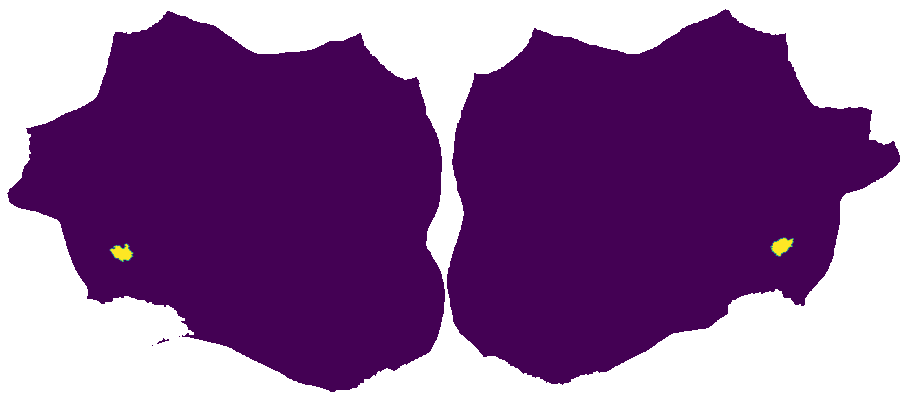

In [966]:
def plot_region(idx, ax):
    roi = np.array([idx])
    roi2 = roi - 180
    temp = np.zeros((360, 1))
    temp[roi] = 2
#     temp[roi2] = 2
    
#     for i in [14, 17, 6, 21, 24, 27, 30, 33, 44, 77, 106, 7, 8, 105, 115, 119, 120, 121, 142]:
#         temp[i] = 1
#         temp[i-180] = 1
    
    ax.imshow(get_flatmap(generate_plot(temp))[0], cmap='viridis')
    ax.axis('off')
    return ax

def plot_max(ax):
    d = batch_subs[1]
    d = np.max(d, axis=(0,1))
    ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    ax.axis('off')
    return ax

index = [65, 245]
r = idx_to_region(index)#[1].split("_")[0]
print(f"Index: {index} // Region: {r[0].values} // {r[1].values}" )


fig, ax = plt.subplots(1,1,figsize=(16,9))
ax = plot_region(index, ax)
# ax = plot_max(ax)


# ax.text(0, 0, "Middle", ha="center", va="center", rotation=0, size=15,)
# ax.text(150, 0, "Middle", ha="center", va="center", rotation=0, size=15,)
# ax.annotate("HELLO",
#             xy=(1125,550), xycoords='data',
#             xytext=(0, 0), textcoords='data',
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="angle3", color='r', ),
#             )



plt.show()

# Multi-head Attention

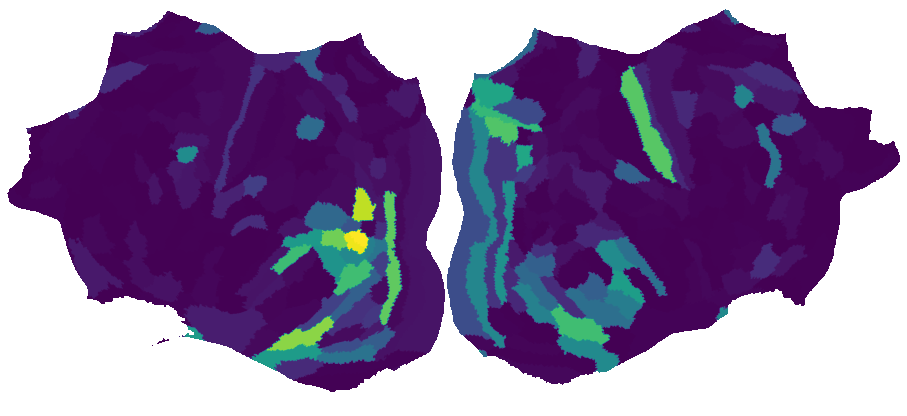

In [37]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

d = mha[6]
# d = np.mean(d, axis=(0,1))
d = np.max(d, axis=(0,1))



ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

# plt.savefig(f"{plots_dir}/max_sub2.png", bbox_inches='tight')

plt.show()

In [27]:
d_idx = np.argsort(d)[::-1]
for i in range(10):
    print(i+1, "-", idx_to_region(d_idx[i])[0])

1 - Eighth_Visual_Area_R
2 - Middle_Temporal_Area_L
3 - Medial_Superior_Temporal_Area_L
4 - Fusiform_Face_Complex_L
5 - Fusiform_Face_Complex_R
6 - Area_TemporoParietoOccipital_Junction_3_L
7 - Area_TemporoParietoOccipital_Junction_2_L
8 - Area_V4t_L
9 - Area_Lateral_Occipital_2_L
10 - Area_Lateral_Occipital_3_L


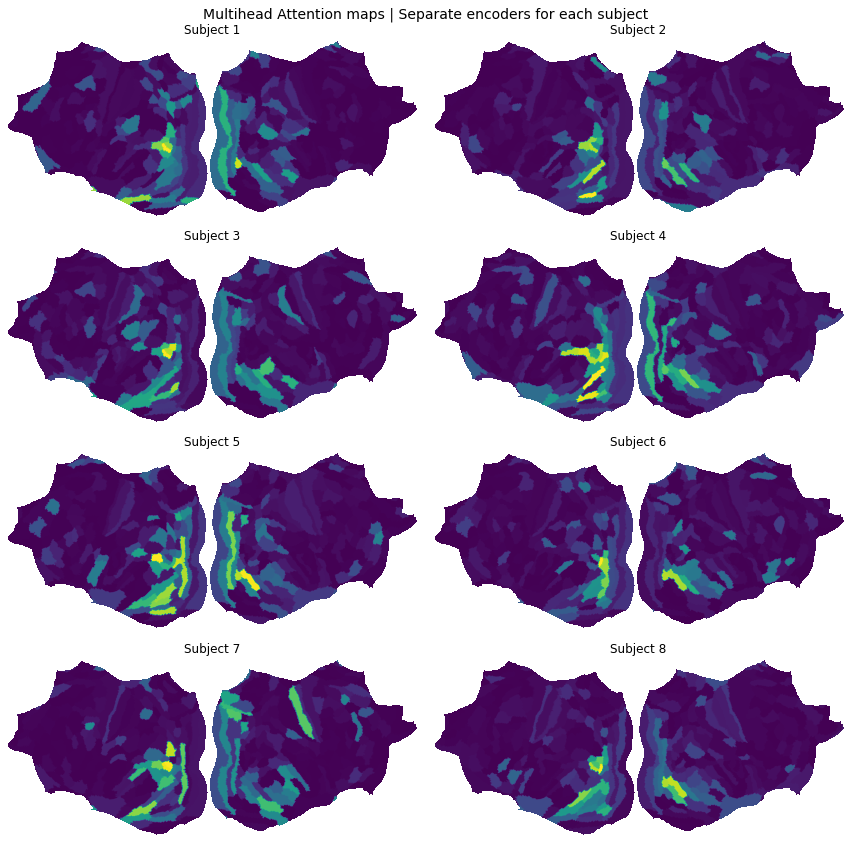

In [18]:
# 8 subjects
fig, ax = plt.subplots(4,2, figsize=(12,12))

for i, a in enumerate(ax.flatten()):
    d = mha[i]
    d = np.max(d, axis=(0,1))
#     d = np.log(d)
    a.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
    a.axis('off')
    a.set_title(f"Subject {i+1}")

plt.suptitle("Multihead Attention maps | Separate encoders for each subject", fontsize=14)
plt.tight_layout()
# plt.savefig(f"{plots_dir}/separate_encoders_mix_batches.png", bbox_inches='tight')
plt.show()

In [22]:
print(batch_subs.shape)
print(mha.shape)

(8, 515, 15, 360)
(8, 515, 15, 360)


0.7716029644022565
0.8450229767691283
0.8125299403463279
0.8236763572651827
0.8208646637861544
0.7982690383784429
0.8127145315096204
0.8475833095333114


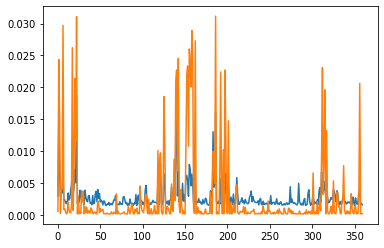

In [30]:
plt.plot(np.mean(mha[0], axis=(0,1)))
plt.plot(np.mean(batch_subs[0], axis=(0,1)))

for i in range(8):
    print(np.corrcoef(np.mean(mha[i], axis=(0,1)), np.mean(batch_subs[i], axis=(0,1)))[1,0])

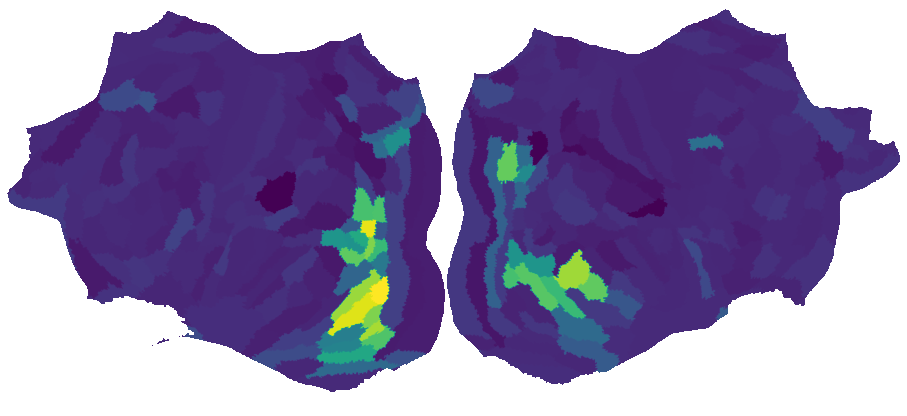

In [23]:
d = batch_subs[0] - mha[0]
d = np.mean(d, axis=(0,1))

fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.imshow( get_flatmap(generate_plot( d ))[0] , cmap='viridis') 
ax.axis('off')

# plt.savefig(f"{plots_dir}/max_sub2.png", bbox_inches='tight')

plt.show()